<div align="center"><h1>Banknote Authentication K-NN Classification Data Science Report</h1></div>


<h3>Introduction</h3>

Counterfeit money is imitation currency produced without the legal permission of the state or government, usually in a conscious attempt to imitate that currency and to deceive its recipient (Counterfeit Prevention). The usage of counterfeit notes is considered to be a fraud and can have adverse side effects on a country's economy. Governments have to come up with may ways of detecting forged banknotes and withdrawing them from preventing them from entering circulation. For this data science project proposal, we will be exploring banknote identification using a dataset from the UCI Machine Learning Repository. The data collected comprises of analysis done on 400x400 pixel gray-scale images taken from genuine and forged banknote-like examples. 

The data set was gathered using an industrial camera, and a wavelet transform tool was used to extract features from the images. A wavelet transform tool is a mathematical function that analyzes essential aspects of an image (noise, intensity, bits/pixel, levels), and these values form a distribution. Just like any distribution, different statistics are used to analyze the shape of the distribution forms. In our case, the statistics used are variance (how dispersed everything is), skewness (how asymmetrical the distribution is), kurtosis (how peaked the distribution is) and entropy (amount of detailed information within an image). The final column is class, which has either a 0 value meaning banknote is authentic or a value of 1, which means that the note is forged.

With this data set, we will be answering the question, *can we use data gathered from the digital image analysis of banknotes to predict whether a banknote is forged or authentic?*


<h3>Exploratory Data Analysis</h3>

Primarily, we load the relevant packages and then read the dataset, which is in a CSV format, from the repository into Jupyter.

In [1]:
#loading the relevant packages
library(tidyverse)
library(repr)
library(readxl)
library(caret)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



<h4>Table 1.0: Preview of Banknote Authentication Dataset</h4>

In [2]:
# read data into R
b_note_data<-read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", 
                      col_names = c("variance", "skewness", "curtosis", "entropy", "class"))

#give a preview of the data
head(b_note_data)

Parsed with column specification:
cols(
  variance = col_double(),
  skewness = col_double(),
  curtosis = col_double(),
  entropy = col_double(),
  class = col_double()
)


variance,skewness,curtosis,entropy,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.62160,8.6661,-2.8073,-0.44699,0
4.54590,8.1674,-2.4586,-1.46210,0
3.86600,-2.6383,1.9242,0.10645,0
3.45660,9.5228,-4.0112,-3.59440,0
0.32924,-4.4552,4.5718,-0.98880,0
4.36840,9.6718,-3.9606,-3.16250,0


The first four columns do not require any modification however since we are predicting a label, which is a categorical value, the 'class' column has to be changed from having numerical values to categorical ones. This is done by changing the integer values 0 and 1 to 'Authentic' and 'Forged' respectively.

<h4>Table 1.1: Dataset after converting the 'class' column</h4>

In [3]:
#change the class column variable from a numerical one to a categorial one.
bnd<-mutate(b_note_data, class = ifelse(class == 0, "Authentic", "Forged"))
head(bnd)


variance,skewness,curtosis,entropy,class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.62160,8.6661,-2.8073,-0.44699,Authentic
4.54590,8.1674,-2.4586,-1.46210,Authentic
3.86600,-2.6383,1.9242,0.10645,Authentic
3.45660,9.5228,-4.0112,-3.59440,Authentic
0.32924,-4.4552,4.5718,-0.98880,Authentic
4.36840,9.6718,-3.9606,-3.16250,Authentic


Now we use the group_by + summarize() functions to find out the percentage and number of observations of each class. The purpose of 
doing this is to see how well represented either class is in the dataset and ensure that there is no underrepresentation/ class imbalance.

<h4>Table 1.2: Number of Observations and Percentage of Forged and Authentic Banknotes <h4>

In [4]:
# Percentage of forged bank notes and authentic bank notes, to check that both are well represented in the dataset.

num_obs <- nrow(bnd)
bnd %>% 
  group_by(class) %>% 
  summarize(n = n(),
            percentage = n() / num_obs * 100)


class,n,percentage
<chr>,<int>,<dbl>
Authentic,762,55.53936
Forged,610,44.46064


We see that 55.54% are 'Authentic' and 44.46% are 'Forged'. There does not seem to be an underrepresentation (class imbalance) of either class value. 

Now we standardize and randomize the data set to eliminate any bias before splitting it into a training and testing set for the classifier.

In [5]:
#Randomize data set, standardize it and split it into a 75% / 25% partition (trainig and testing data set)
set.seed(3456) 
bnd_scaled <- bnd%>%
mutate(scaled_variance = scale(variance, center = TRUE),
       scaled_skewness = scale(skewness, center = TRUE),
       scaled_curtosis = scale(curtosis, center = TRUE),
       scaled_entropy = scale(entropy, center = TRUE))


training_rows <- bnd_scaled %>% 
  select(class) %>% 
  unlist() %>% 
  createDataPartition(p = 0.75, list = FALSE)


In [6]:
#Form the training and testing datasets
training_set<- bnd_scaled %>% slice(training_rows)
testing_set <- bnd_scaled %>% slice(-training_rows)


The variables in the dataset are all quite abstract values generated from a mathematical function and it is hard to understand the meaning of these numbers and what they say about a banknote image (apart from entropy since it measures the amount of noise in an image) without further analysis. Thus, we use the ggpairs() function to plot the four different variable values against each other and gain an understanding of how significant each variable is in choosing a corresponding class label.

<h4>Figure 1.0: A Number of Different Visualizations to Compare  Variables Values  </h4>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


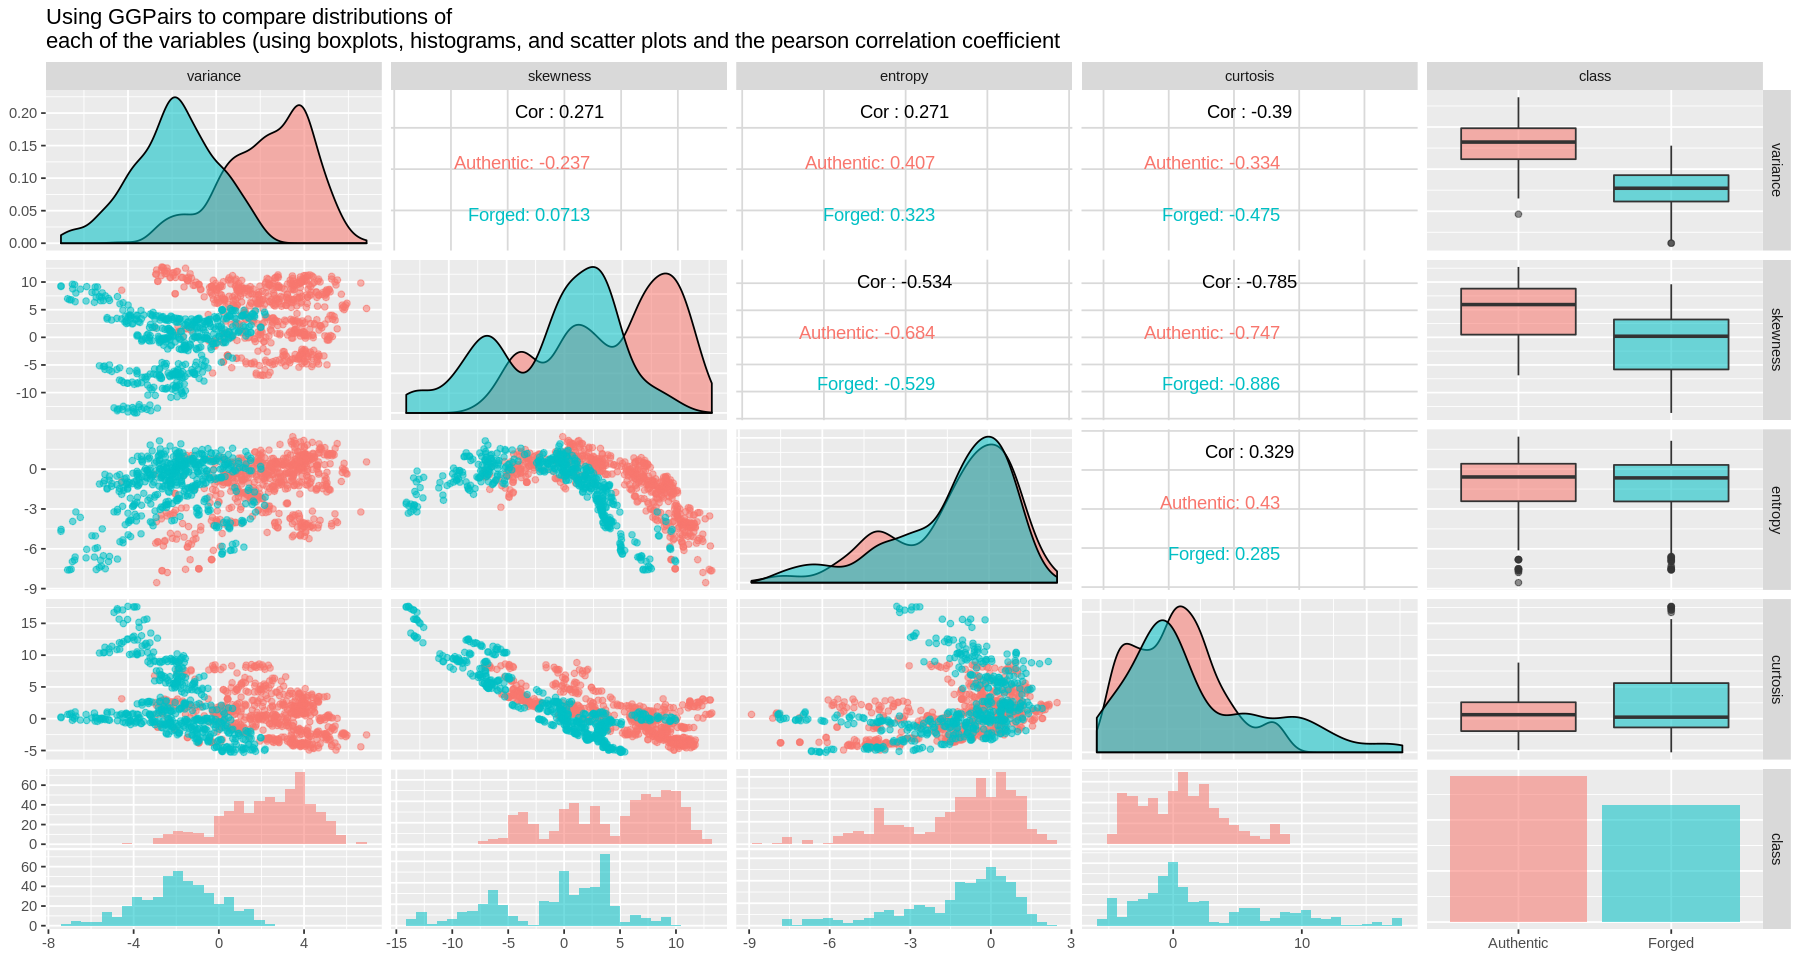

In [7]:

options(repr.plot.width = 15, repr.plot.height = 8) 

b_note_data3<-select(training_set, variance, skewness, entropy, curtosis, class)
ggpairs(data=b_note_data3, ggplot2::aes(colour=class, alpha = 0.4), title = 'Using GGPairs to compare distributions of 
each of the variables (using boxplots, histograms, and scatter plots and the pearson correlation coefficient')


We make the following observations:
- Looking at the boxplots in the 5th column, the entropy vs. class boxplot shows that both 'Forged' and 'Authentic' notes have a very similar interquartile range, mean, maximum and minimum. Thus entropy does not seem to have that much of an affect on whether a banknote is forged or authentic in comparison to the other three boxplots.
- Looking at the scatterplots, there are regions for each column where there is a strong amount of overlap as well as regions where there is little to no overlap. 
- There seems to be a strong negative correlation between 'curtosis' and 'skewness' and a weak / nonexistent correlation between the remaining variables.

Although entropy seems like a less likely contender than the others, looking at the entropy vs. skewness scatterplot (row 3, column 2), the classes seem to be inseperable in some regions and clearly seperable in others. Thus, we decide to use all four variables as predictor variables since they all seem to contribute to the labelling of the classes.

<h3>Classification Analysis</h3>


Now that we have our predictor variables and tidy data that has been split into a training and testing set, we further divide our the sets into the following: 
 
- X_train: A data frame containing the explanatory variables from the training dataset.
- Y_train: A vector containing the class labels from the training dataset. (the values from the ‘class’ column.)
- X_test: A data frame containing the explanatory variables from the testing dataset.
- Y_test: A vector containing the class labels from the testing dataset. (the values from the ‘class’ column.)


Together, X_train and Y_train will be used to train our knn algorithm.

In [36]:
#Pre-process the data
scale_transformer <- preProcess(training_set, method = c("center", "scale")) 
training_set <- predict(scale_transformer, training_set)
test_set <- predict(scale_transformer, testing_set)


#Split the data into predictors and class labels so we can feed it to the classifier.
X_train <- training_set %>% 
  select(variance, skewness, curtosis, entropy) %>% 
  data.frame()
Y_train <- training_set %>% 
  select(class) %>% 
  unlist()
X_test <- test_set %>% 
  select(variance, skewness, curtosis, entropy) %>% 
  data.frame()
Y_test <- test_set %>% 
  select(class) %>% 
  unlist()


To find an optimal value for the k nearest neighbors, we will use five-fold cross-validation construct our final model with that optimal k value. 
Then we will feed X_test to our final model and compare its predictions to Y_test in order to check its accuracy.



<h4>Table 1.3: A Table to Show the Accuracy of Different k values using 5-fold Cross Validation</h4>

In [39]:
#create a dataframe for different values of k so we can pick the optimal one.
ks <- data.frame(k = c(1,3,5,7,9,11))


#Use folder as 10 to do the cross-validation
set.seed(1234) 
train_control <- trainControl(method = "cv", number = 5)
choose_k <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
choose_k


k-Nearest Neighbors 

1030 samples
   4 predictor
   2 classes: 'Authentic', 'Forged' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 823, 825, 823, 824, 825 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9980488  0.9960522
   3  0.9980488  0.9960522
   5  0.9980488  0.9960522
   7  0.9961258  0.9921756
   9  0.9941935  0.9882711
  11  0.9912714  0.9823655

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

<h4>Figure 1.1: A Scatterplot to show the different K Values and their Respective Accuracies</h4>

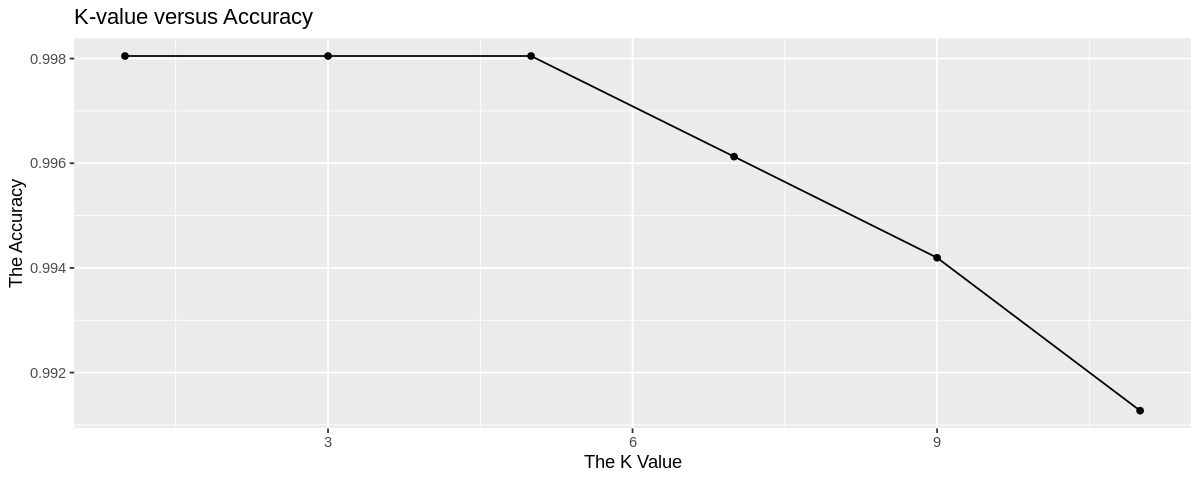

In [40]:
#plot the accuracy of k and then choose the best k
options(repr.plot.width=10, repr.plot.height=4)
k_accuracies <- choose_k$results %>%
                    select(k, Accuracy)
choose_k_plot <- ggplot(k_accuracies, aes(x = k, y = Accuracy)) +
                    geom_point()+
                    geom_line()+
                    labs(x = "The K Value", y = "The Accuracy", title = "K-value versus Accuracy")
choose_k_plot


According to this scatterplot, it seems that 1, 3, or 5 all make good choices as they all predict classes with a 99.8% accuracy. 
Since it does not matter which value out of the three we pick, let us choose k = 5 as the optimal value. Now as stated before, we now use this optimal k value on the X_test set to see how accurately it predicts the class label. Once the final prediction is made, we display our results in a confusion matrix which provides us with a tabular summary of how many 'Authentic' and 'Forged' banknotes our algorithm predicted there were there versus the actual number of 'Forged' and 'Authentic' banknotes.

In [11]:
final_k <- data.frame(k = 5)
#Set the optimal value of k according to our graph above.

final_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = final_k)
#Train the model using our optimal k value and the training dataset.

final_prediction<-predict(final_model, X_test)
#Predict the class labels from the testing dataset.


final_results <- confusionMatrix(table(final_prediction, Y_test))
#compare the predictions to the actual values and visualise it using a confusion matrix.


final_results


Confusion Matrix and Statistics

                Y_test
final_prediction Authentic Forged
       Authentic       189      0
       Forged            1    152
                                          
               Accuracy : 0.9971          
                 95% CI : (0.9838, 0.9999)
    No Information Rate : 0.5556          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9941          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9947          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9935          
             Prevalence : 0.5556          
         Detection Rate : 0.5526          
   Detection Prevalence : 0.5526          
      Balanced Accuracy : 0.9974          
                                          
       'Positive' Class :

<h4>Figure 1.2: A Fourfold Plot to Visualise the Confusion Matrix</h4>

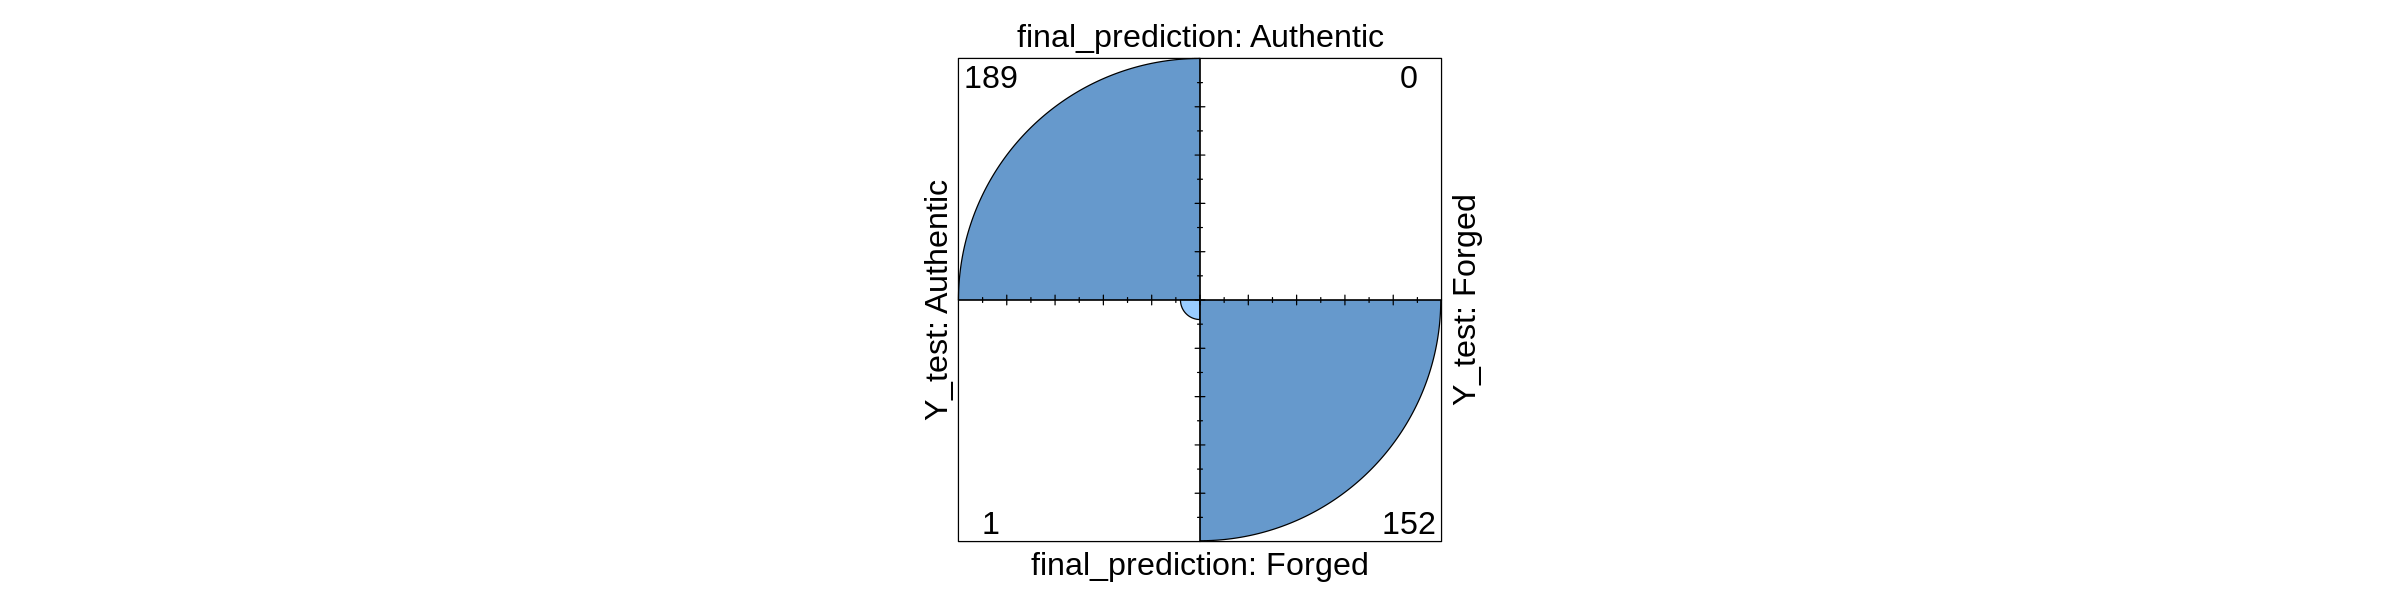

In [34]:
options(repr.plot.width = 20, repr.plot.height = 5) 

fourfoldplot(final_results$table, conf.level = 0,   margin = c(1), space = 0.15)

<h3>Discussion and Findings</h3>

According to the confusion matrix, out of the 190 'Authentic' samples in the dataset, only one was predicted incorrectly and out of the 152 'Forged' samples in the dataset, there were 0 incorrect predictions. The Y_test contained 342 banknote observations and the algorithm, when the K value was picked to be 5 was able to classify 341 out of those 342 observations correctly, implying a 99.7% accuracy rate. This aids us in answering our research question that data gathered from image analysis can be used to predict whether a banknote is forged or authentic. 


Given the dataset was taken from the UCI Machine Learning Repository, we expected tidying the data and splitting it to be a relatively straight forward task and correctly so, however, we did not expect the algorithm, when actually predicting a class label from the testing set to be this accurate. 


In regards to the impact that these findings will have, whether performing a knn classification analysis to identify counterfeit notes is beneficial or useful depends who uses it. Businesses, casinos, small banks and countries that have completed or are in the phase of completing their transition towards a cashless economy can use this model. The reason for this is because they have a significantly lower volume of cash transactions being made, thus 1/342 observations being wrong is not a problem and by using this model, they have a simple and efficient way of detecting counterfeit notes. 

On the other hand, countries with weak currencies and countries where cash is still the primary payment method may not find this model to be efficient as the volume of cash that they are dealing with is significantly higher and the K-NN will not scale as well. 



It seems that whatever observation existed in the testing set, the algorithm was able to predict with ease. One reason for this may be that there was only one technique used to create the forged notes. Perhaps the entropy, curtosis and variance levels were randomized in a very systematic manner to create forged notes and the algorithm was able to detect that when being trained on the training set. This leads us to ask the question, would this algorithm be as efficient on a dataset where different forgery techniques are used?


<h3> References </h3>

Timbers, Tiffany-Anne Campbell, Trevor Lee, Melissa. Introduction to Data Science. 2020.

Bank of Canada. *Counterfeit Prevention.* www.bankofcanada.ca/banknotes/counterfeit-prevention/.

Lohweg, Volker. *Banknote Authentication Data Set.* http://archive.ics.uci.edu/ml/datasets/banknote+authentication. 2012.
